In [13]:
import process as process
from models.Lorenz63 import lorenz63_dxdt
from random_variables import GaussianRV, RV
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# System dimension
nx = 3
# Numerical solver resolution
dt = 0.01
# Steps between observations
dk = 10
# State model
f = process.operators_from_autonomous_ODE(lorenz63_dxdt, nx, dt, dk)
# Model error
sigma_q = 0.3
Q = np.eye(nx) * sigma_q
q = process.gaussian_constant_noise(0, Q)

# Observation space dimension
m = 3
# Observation operator
h = process.fixed_linear_operator(np.eye(m))
# Observational error
sigma_r = 0.3
R = np.eye(m) * sigma_r
r = process.gaussian_constant_noise(0, R)

# Initial distribution
X0_mean = np.ones(nx)
X0_cov = np.eye(nx)
X0 = GaussianRV(X0_mean, X0_cov)

# Number of cycles
ncy = 250

# DA model
true_process = process.Process(ncy, X0, f, q, h, r)

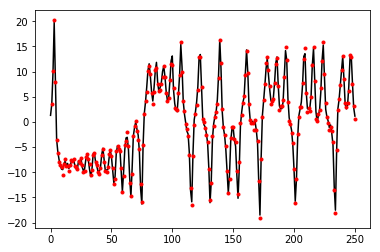

In [3]:
import da_tools.simulate as simulate

xt, y = simulate.simulate_truth_and_obs(true_process)

plt.plot(xt[0, :], 'k-')
plt.plot(y[0, :], 'r.')

In [14]:
from da_tools.EnKF import EnKF
from da_tools.ETPF import ETPF
from da_tools.tempered_PF import tempered_PF as TPF

import tools.diagnostics as diag
n_ens = np.arange(10, 110, 10)

In [5]:
RMSE_EnKF = np.zeros(len(n_ens))
cov_EnKF = np.zeros(len(n_ens))

for i, ne in enumerate(n_ens):
    np.random.seed(2000)
    enkf = EnKF(ne)
    try:
        xf, xa = enkf(true_process, y)
        RMSE_EnKF[i] = diag.ensemble_time_series_RMSE(xa, xt)
        cov_EnKF[i] = diag.ensemble_time_series_coverage(xa, xt)
    except:
        RMSE_EnKF[i] = np.nan
        cov_EnKF[i] = np.nan

In [6]:
RMSE_ETPF = np.zeros(len(n_ens))
cov_ETPF = np.zeros(len(n_ens))

for i, ne in enumerate(n_ens):    
    np.random.seed(2000)

    etpf = ETPF(ne)
    try:
        xf, xa = etpf(true_process, y)
        RMSE_ETPF[i] = diag.ensemble_time_series_RMSE(xa, xt)
        cov_ETPF[i] = diag.ensemble_time_series_coverage(xa, xt)
    except:
        RMSE_ETPF[i] = np.nan
        cov_ETPF[i] = np.nan
        

ETPF 10:  65%|██████▌   | 163/250 [00:01<00:00, 102.85it/s]/home/tade/Documents/doctorado/daba_tpf/da_tools/ETPF.py:21: RuntimeWarning: invalid value encountered in true_divide
  w /= np.sum(w)
/home/tade/anaconda3/lib/python3.7/site-packages/ot/lp/__init__.py:113: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


In [7]:
RMSE_TPF = np.zeros(len(n_ens))
cov_TPF = np.zeros(len(n_ens))

for i, ne in enumerate(n_ens):
    np.random.seed(2000)
    tpf = TPF(ne)
    try:
        xf, xa = tpf(true_process, y)
        RMSE_TPF[i] = diag.ensemble_time_series_RMSE(xa, xt)
        cov_TPF[i] = diag.ensemble_time_series_coverage(xa, xt)
    except:
        RMSE_TPF[i] = np.nan
        cov_TPF[i] = np.nan

In [8]:
RMSE = [RMSE_EnKF, RMSE_ETPF, RMSE_TPF]
cov = [cov_EnKF, cov_ETPF, cov_TPF]

In [10]:
import pickle
with open('results/ensemble_size/RMSE.pkl', 'wb') as file:
    pickle.dump(RMSE, file)
with open('results/ensemble_size/cov.pkl', 'wb') as file:
    pickle.dump(cov, file)

In [11]:
import pickle
with open('results/ensemble_size/RMSE.pkl', 'rb') as file:
    RMSE_EnKF, RMSE_ETPF, RMSE_TPF = pickle.load(file)
with open('results/ensemble_size/cov.pkl', 'rb') as file:
    cov_EnKF, cov_ETPF, cov_TPF = pickle.load(file)

In [51]:
%matplotlib qt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(n_ens, RMSE_EnKF, color='tab:green', marker='.', label='EnKF')
ax1.plot(n_ens, RMSE_TPF, color='tab:orange', marker='.', label='TPF')
ax1.plot(n_ens, RMSE_ETPF, color='tab:red', marker='.', label='ETPF')
ax1.set_ylabel('RMSE')

# ax2 = ax1.twinx()
ax2.plot(n_ens, cov_EnKF, color='tab:green', marker='.', label='EnKF')
ax2.plot(n_ens, cov_TPF, color='tab:orange', marker='.', label='TPF')
ax2.plot(n_ens, cov_ETPF, color='tab:red', marker='.', label='ETPF')
ax2.set_ylabel('Cobertura')
ax2.set_xlabel('Tamaño del ensamble')
ax2.axhline(y=0.95, color='k', ls='--')

ax2.legend(ncol=3)
plt.subplots_adjust(hspace=0.1)
